In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

# 1. How do the faculty and university you graduated from affect your career?

## Data Collection

#### Education Data


In [12]:
education_df = pd.read_csv('../data/preprocessed-data/normalized csv/educations.csv')
education_df = education_df[education_df['university_name'] != 'iti']
education_df.head()

,University,Degree,Date,User,university_name,faculty_name
1,ain shams university,"bachelor's degree, computer science",2016 - 2020,%D9%90%D9%90amiraelmergawy,ain shams,computer
3,al-azhar university,geophysics and seismology,Sep 2015 - Aug 2019,-ezz,azhar,NaN
4,"faculty of petroleum and mining engineering, s...","bachelor's degree, petroleum engineering",2015 - 2020,1212mohamedtaha,NaN,engineering
6,al-azhar university,"bachelor of engineering, computer engineering",2013 - 2018,3omarbadr,azhar,computer
7,ain shams university,"bachelor of engineering (b.eng.), computers an...",2013 - 2018,a-mohsen,ain shams,computer


#### Career Data

In [15]:
experience_df = pd.read_csv('../data/preprocessed-data/normalized csv/experiences.csv')
experience_df = experience_df[(experience_df['title_tag'] != 'internship') & (experience_df['EmploymentType'] != 'Internship')]
experience_df = experience_df[(experience_df['title_tag'] != 'student') & (experience_df['title_tag'] != 'teaching')]
experience_df.head()

,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
4,-ezz,https://www.linkedin.com/company/30101254/,sonono,software engineer,Full-time,2022-01-01,Present,16.0,"Basel, Switzerland",software
6,-ezz,UNKNOWN,CEL - Consulting Engineering Bureau,senior geotechnical engineer,Full-time,2019-09-01,Aug 2020,12.0,Egypt,NaN
7,1212mohamedtaha,https://www.linkedin.com/company/777868/,Etisalat Misr,big data engineer,Full-time,2022-05-01,Present,12.0,"New Cairo, Cairo, Egypt",data
9,1212mohamedtaha,https://www.linkedin.com/company/2229028/,"The Translation Gate, LLC",english / arabic translator,Freelance,2021-01-01,Mar 2021,3.0,Remote,NaN
10,3omarbadr,https://www.linkedin.com/company/18899346/,ACME SAICO - Integrated Engineering Systems -(...,software engineer,Full-time,2022-09-01,Present,8.0,"Heliopolis, Cairo, Egypt",software


In [16]:
# make sure that every user has one and only one experience with the same company
experience_df = experience_df.drop_duplicates(subset=['User', 'Company'], keep='first')
experience_df.head()

,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
4,-ezz,https://www.linkedin.com/company/30101254/,sonono,software engineer,Full-time,2022-01-01,Present,16.0,"Basel, Switzerland",software
6,-ezz,UNKNOWN,CEL - Consulting Engineering Bureau,senior geotechnical engineer,Full-time,2019-09-01,Aug 2020,12.0,Egypt,NaN
7,1212mohamedtaha,https://www.linkedin.com/company/777868/,Etisalat Misr,big data engineer,Full-time,2022-05-01,Present,12.0,"New Cairo, Cairo, Egypt",data
9,1212mohamedtaha,https://www.linkedin.com/company/2229028/,"The Translation Gate, LLC",english / arabic translator,Freelance,2021-01-01,Mar 2021,3.0,Remote,NaN
10,3omarbadr,https://www.linkedin.com/company/18899346/,ACME SAICO - Integrated Engineering Systems -(...,software engineer,Full-time,2022-09-01,Present,8.0,"Heliopolis, Cairo, Egypt",software


In [17]:
experience_df = experience_df[experience_df['Company'] != 'Information Technology Institute (ITI)']


#### Skills Data

In [18]:
skills_df = pd.read_csv('../data/preprocessed-data/normalized csv/skills.csv')

# flatten the 3 skills columns into one column
skills_df = skills_df.melt(id_vars=['User'], value_vars=['Skill1', 'Skill2', 'Skill3'], value_name='skill')

## EDA

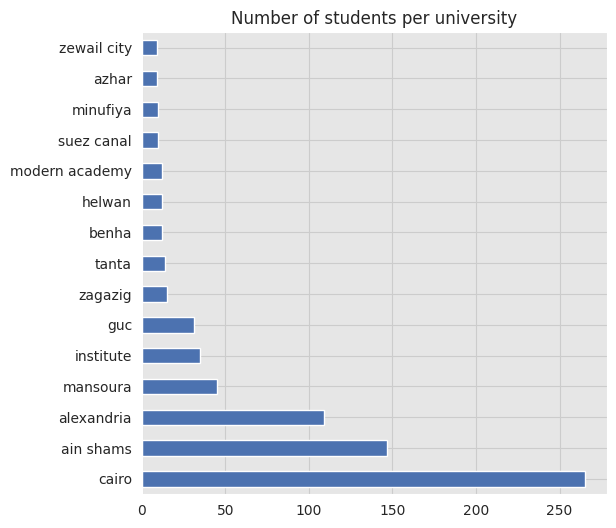

In [40]:
# plot the distribution of number of students per education
education_df['university_name'].value_counts().sort_values(ascending=False)[:15].plot(kind='barh', figsize=(6, 6))
plt.title('Number of students per university')
plt.show()

#### 1.1 University vs field

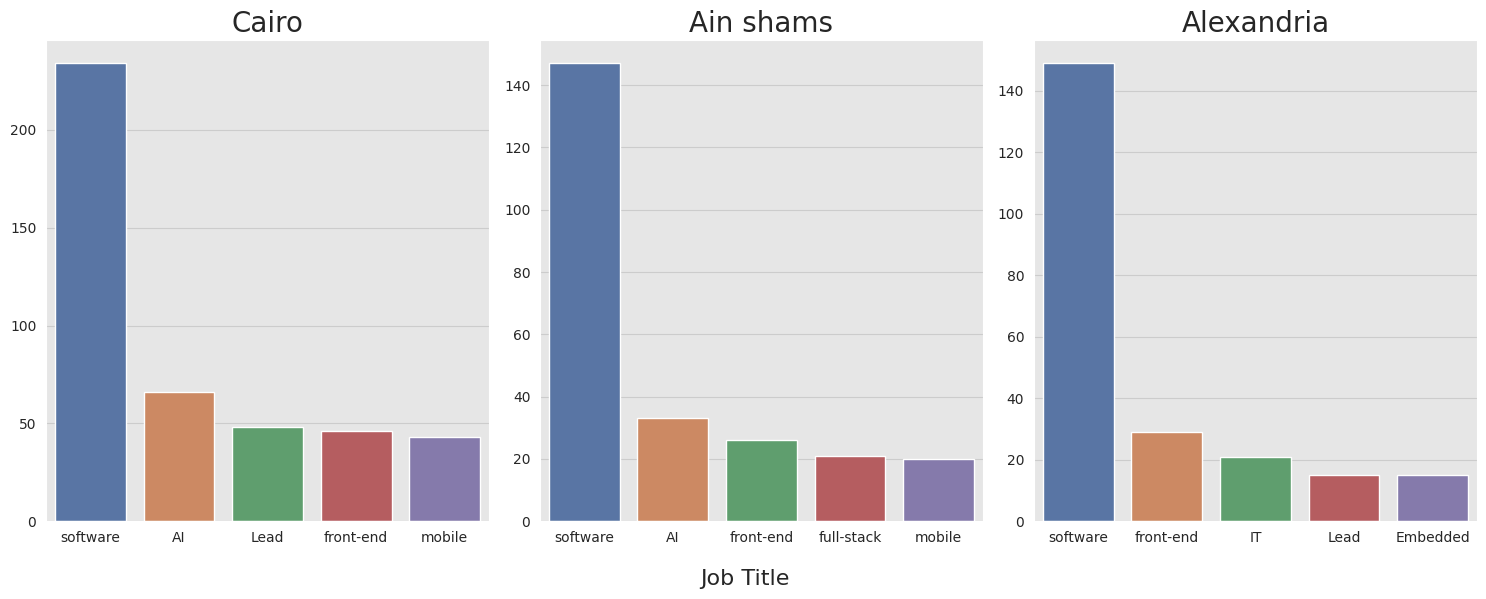

In [43]:
# join education and experience dataframes
merged_df = pd.merge(education_df, experience_df, on='User', how='inner')
df = merged_df.groupby('university_name')['title_tag'].value_counts().sort_values(ascending=False)
df = df.to_frame().rename(columns={'title_tag': 'count'}).reset_index()
universities = ['cairo', 'ain shams', 'alexandria']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# plot the distribution of number of students per education
for university in universities:
    # row = universities.index(university) // 3
    col = universities.index(university) % 3
    d = df[df['university_name'] == university].sort_values(by='count', ascending=False)[:5]
    sns.barplot(x='title_tag', y='count', data=d, ax=axes[col])
    axes[col].set_title(university.capitalize(), fontsize=20)
    axes[col].set_xlabel(None)
    axes[col].set_ylabel(None)

# set outer x label and make the plot look nicer
fig.supxlabel('Job Title', fontsize=16)
fig.tight_layout()
plt.show()
    

In [51]:
# hypothesis: the university you graduate from affects your job title
# test: chi-square test
from scipy.stats import chi2_contingency

# get the top 5 job titles for each university
universities = ['cairo', 'ain shams', 'alexandria']
titles = ['software', 'AI', 'data', 'front-end', 'mobile']

# for each university, get the number of students with each title
data = []
for university in universities:
    for title in titles:
        data.append(len(merged_df[(merged_df['university_name'] == university) & (merged_df['title_tag'] == title)]))

# reshape the data into a 2D array
data = np.array(data).reshape(3, 5)

# perform chi-square test
chi2, p, dof, expected = chi2_contingency(data)
print(f'chi2: {chi2}, p: {p}, dof: {dof}')

chi2: 40.62852536325856, p: 2.4458796717524196e-06, dof: 8


#### 1.2 University vs Company

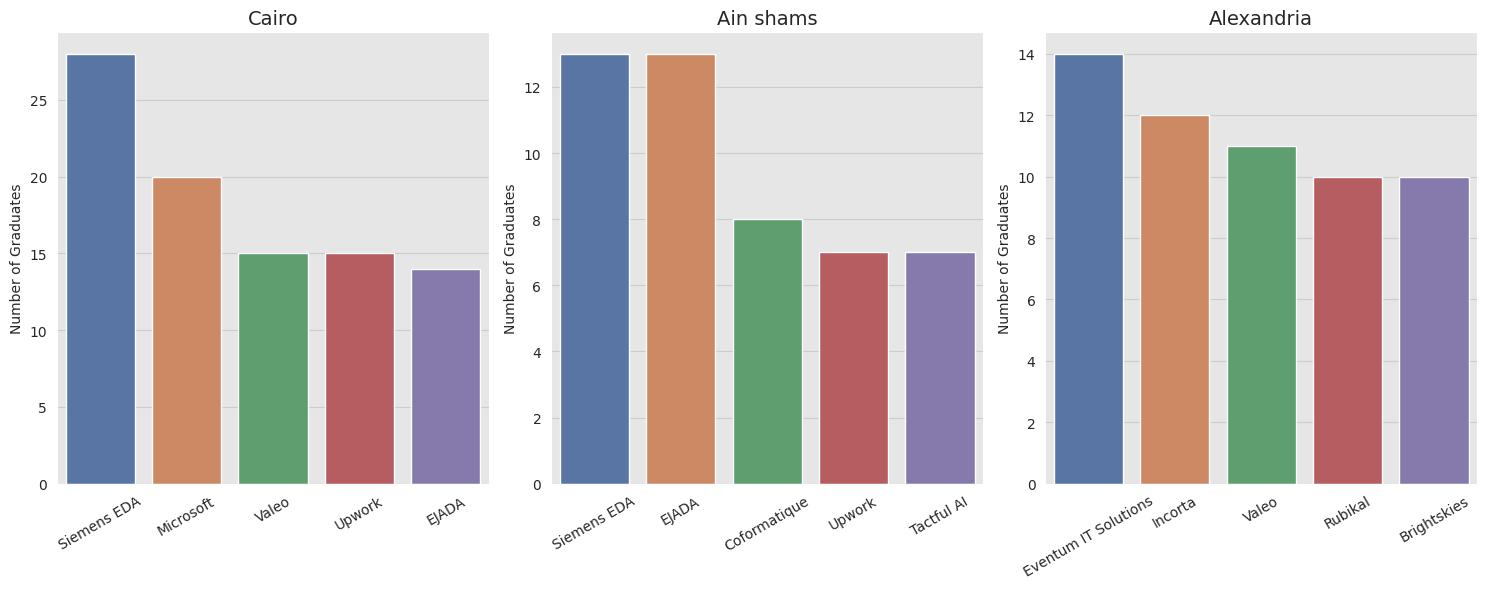

In [38]:
# join education and experience dataframes
merged_df = pd.merge(education_df, experience_df, on='User', how='inner')
df = merged_df.groupby('university_name')['Company'].value_counts().sort_values(ascending=False)
df = df.to_frame().rename(columns={'Company': 'count'}).reset_index()
universities = ['cairo', 'ain shams', 'alexandria']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

# plot the distribution of number of students per education
for university in universities:
    # row = universities.index(university) // 3
    col = universities.index(university) % 3
    d = df[df['university_name'] == university].sort_values(by='count', ascending=False)[:5]
    sns.barplot(x='Company', y='count', data=d, ax=axes[col])
    axes[col].set_title(university.capitalize(), fontsize=14)
    axes[col].set_xlabel(None)
    axes[col].set_ylabel('Number of Graduates')
    axes[col].set_xticklabels(axes[col].get_xticklabels(), rotation=30)

fig.tight_layout()
plt.show()
    

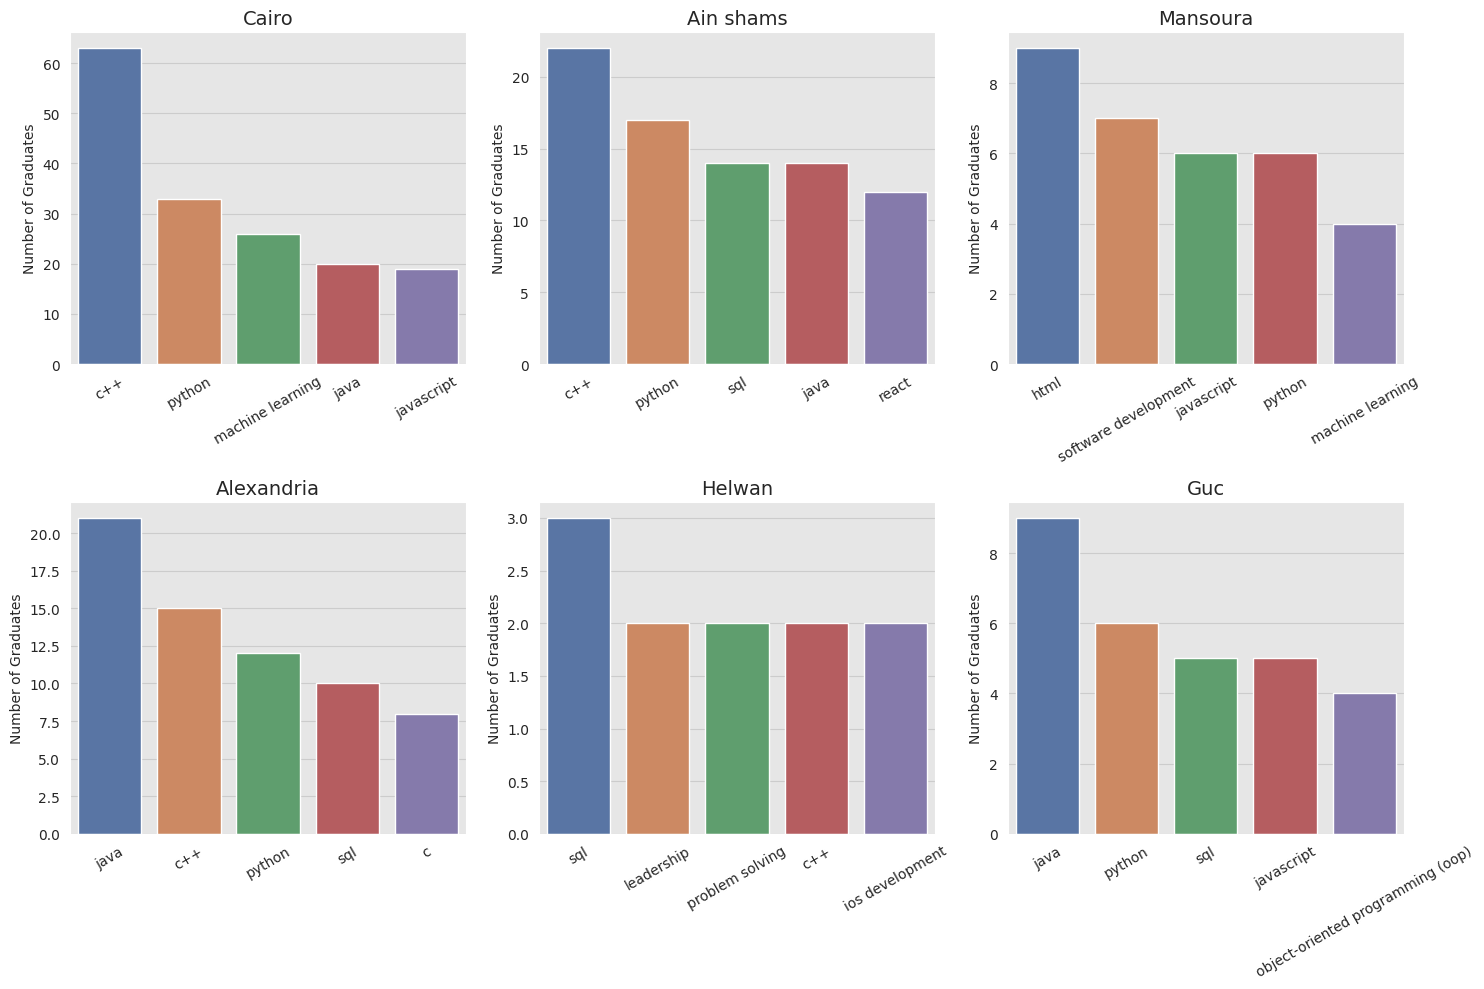

In [14]:
# join education and experience dataframes
merged_df = pd.merge(education_df, skills_df, on='User', how='inner')
df = merged_df.groupby('university_name')['skill'].value_counts().sort_values(ascending=False)
df = df.to_frame().rename(columns={'skill': 'count'}).reset_index()
universities = ['cairo', 'ain shams', 'mansoura', 'alexandria', 'helwan', 'guc']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# plot the distribution of number of students per education
for university in universities:
    row = universities.index(university) // 3
    col = universities.index(university) % 3
    d = df[df['university_name'] == university].sort_values(by='count', ascending=False)[:5]
    sns.barplot(x='skill', y='count', data=d, ax=axes[row, col])
    axes[row, col].set_title(university.capitalize(), fontsize=14)
    axes[row, col].set_xlabel(None)
    axes[row, col].set_ylabel('Number of Graduates')
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=30)

fig.tight_layout()
plt.show()
    

### 2. The relation between joining student activities and working after graduation.

In [70]:
experience_df = pd.read_csv('../data/preprocessed-data/normalized csv/experiences.csv')
experience_df = experience_df.drop_duplicates(subset=['User', 'Company'], keep='first')
experience_df = experience_df[(experience_df['title_tag'] != 'student') & (experience_df['title_tag'] != 'teaching')]
experience_df.head()

,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
1,%D9%90%D9%90amiraelmergawy,https://www.linkedin.com/company/15805726/,National Telecommunication Institute (NTI),mean stack developer,Internship,2020-11-01,Jan 2021,3.0,NaN,full-stack
2,%D9%90%D9%90amiraelmergawy,https://www.linkedin.com/company/18305384/,الجهاز المركزي للتعبئة العامة و الاحصاء,software developer,Internship,2019-07-01,NaN,1.0,"Cairo, Egypt",software
3,%D9%90%D9%90amiraelmergawy,https://www.linkedin.com/company/2205041/,(ISCC) Information Systems and Computers Center,software developer,Internship,2018-08-01,NaN,1.0,"Cairo, Egypt",software
4,-ezz,https://www.linkedin.com/company/30101254/,sonono,software engineer,Full-time,2022-01-01,Present,16.0,"Basel, Switzerland",software
5,-ezz,https://www.linkedin.com/company/294614/,Information Technology Institute (ITI),internship trainee,Full-time,2021-10-01,Jan 2022,4.0,Egypt,internship


In [71]:
volunteer_df = pd.read_csv('../data/preprocessed-data/normalized csv/volunteering.csv')
volunteer_df.head()

,Role,Organization,Date,User
0,Community Development Volunteer,CS Camp,Aug 2019 - Nov 2020 · 1 yr 4 mos,%D9%90%D9%90amiraelmergawy
1,Volunteer translator,Translators without Borders,May 2020 - Present · 3 yrs,1212mohamedtaha
2,Content creator at AAPG Suez blog,AAPG SU SC,Sep 2018 - Dec 2018 · 4 mos,1212mohamedtaha
3,Android Developer,AAPG SU SC,Aug 2017 - Apr 2019 · 1 yr 9 mos,1212mohamedtaha
4,Public Relations Specialist,Az-SENCS | معرض هندسة النظم والحاسبات,Dec 2015 - May 2018 · 2 yrs 6 mos,3omarbadr


In [72]:
volunteer_df = volunteer_df.drop_duplicates(subset=['User', 'Organization'], keep='first')

volunteer_df.groupby('Organization')['User'].count().sort_values(ascending=False)[:10]

Organization
IEEE                                                         54
Resala Charity Organization | جمعية رسالة للأعمال الخيرية    26
Life Makers Foundation                                       10
Enactus                                                       8
AIESEC                                                        8
acmASCIS Student Chapter                                      6
CAT Reloaded                                                  5
ICPC - International Collegiate Programming Contest           5
ASU Racing Team                                               4
Feكra                                                         4
Name: User, dtype: int64

In [73]:
# print the experience dataframe company column
experience_df['Company'].value_counts().sort_values(ascending=False)[:20]

Information Technology Institute (ITI)    78
Valeo                                     53
Upwork                                    49
Vodafone                                  43
Siemens EDA                               42
Microsoft                                 41
EJADA                                     33
Freelance                                 27
Dell Technologies                         27
Tactful AI                                26
_VOIS                                     26
Mentor Graphics                           25
Breadfast                                 25
Coformatique                              21
Incorta                                   19
Brightskies                               17
ITWorx                                    16
Instabug                                  16
Eventum IT Solutions                      16
Egyptian Armed Forces                     16
Name: Company, dtype: int64

In [74]:
# join volunteering and experience dataframes
volunteer_df = pd.merge(volunteer_df, experience_df, on='User', how='inner')
volunteer_df.head()

,Role,Organization,Date,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
0,Community Development Volunteer,CS Camp,Aug 2019 - Nov 2020 · 1 yr 4 mos,%D9%90%D9%90amiraelmergawy,https://www.linkedin.com/company/15805726/,National Telecommunication Institute (NTI),mean stack developer,Internship,2020-11-01,Jan 2021,3.0,NaN,full-stack
1,Community Development Volunteer,CS Camp,Aug 2019 - Nov 2020 · 1 yr 4 mos,%D9%90%D9%90amiraelmergawy,https://www.linkedin.com/company/18305384/,الجهاز المركزي للتعبئة العامة و الاحصاء,software developer,Internship,2019-07-01,NaN,1.0,"Cairo, Egypt",software
2,Community Development Volunteer,CS Camp,Aug 2019 - Nov 2020 · 1 yr 4 mos,%D9%90%D9%90amiraelmergawy,https://www.linkedin.com/company/2205041/,(ISCC) Information Systems and Computers Center,software developer,Internship,2018-08-01,NaN,1.0,"Cairo, Egypt",software
3,Volunteer translator,Translators without Borders,May 2020 - Present · 3 yrs,1212mohamedtaha,https://www.linkedin.com/company/777868/,Etisalat Misr,big data engineer,Full-time,2022-05-01,Present,12.0,"New Cairo, Cairo, Egypt",data
4,Volunteer translator,Translators without Borders,May 2020 - Present · 3 yrs,1212mohamedtaha,https://www.linkedin.com/company/294614/,Information Technology Institute (ITI),student trainee,Full-time,2021-04-01,Feb 2022,11.0,"El Mansoura, Ad Daqahliyah, Egypt",internship


In [75]:
# get the people who doesn't have volunteering
no_volunteer_df = experience_df[~experience_df['User'].isin(volunteer_df['User'])]
no_volunteer_df.head()

,User,CompanyUrl,Company,Title,EmploymentType,From,To,Duration,Location,title_tag
4,-ezz,https://www.linkedin.com/company/30101254/,sonono,software engineer,Full-time,2022-01-01,Present,16.0,"Basel, Switzerland",software
5,-ezz,https://www.linkedin.com/company/294614/,Information Technology Institute (ITI),internship trainee,Full-time,2021-10-01,Jan 2022,4.0,Egypt,internship
6,-ezz,UNKNOWN,CEL - Consulting Engineering Bureau,senior geotechnical engineer,Full-time,2019-09-01,Aug 2020,12.0,Egypt,NaN
23,a-nan-farag-b78a0b12b,https://www.linkedin.com/company/235489/,KnowledgeNet,senior java developer,Full-time,2021-05-01,Present,24.0,"Cairo, Egypt",software
24,a-nan-farag-b78a0b12b,https://www.linkedin.com/company/27089843/,DG-Well,senior java software engineer,NaN,2018-05-01,May 2021,37.0,NaN,software


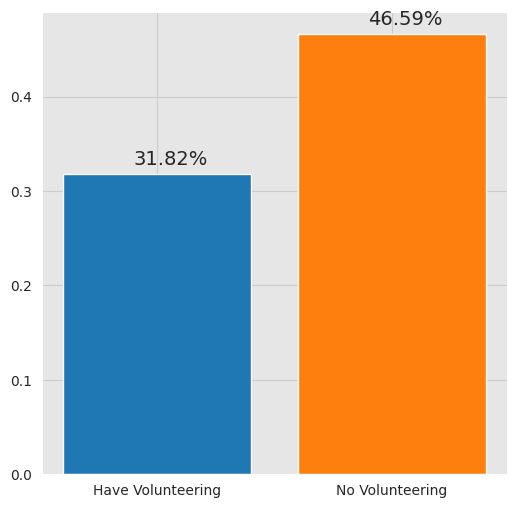

In [85]:
# plot the ratio of people with title_tag == 'Lead' and have volunteering to people with title_tag == 'Lead' and doesn't have volunteering
plt.figure(figsize=(6, 6))
total = experience_df[experience_df['title_tag'] == 'Lead'].shape[0]
plt.bar(['Have Volunteering', 'No Volunteering'], [len(volunteer_df[volunteer_df['title_tag'] == 'Lead']['User'].unique()) / total, 
                                                  len(no_volunteer_df[no_volunteer_df['title_tag'] == 'Lead']['User'].unique())  / total]
         , color=['#1f77b4', '#ff7f0e'])

# add text to the bars
plt.text(x=-0.1, y=len(volunteer_df[volunteer_df['title_tag'] == 'Lead']['User'].unique()) / total + 0.01, s=str(round(len(volunteer_df[volunteer_df['title_tag'] == 'Lead']['User'].unique()) / total * 100, 2)) + '%', size=14)
plt.text(x=0.9, y=len(no_volunteer_df[no_volunteer_df['title_tag'] == 'Lead']['User'].unique()) / total + 0.01, s=str(round(len(no_volunteer_df[no_volunteer_df['title_tag'] == 'Lead']['User'].unique()) / total * 100, 2)) + '%', size=14)
plt.show()

#### Relation between joining student activities and Companies

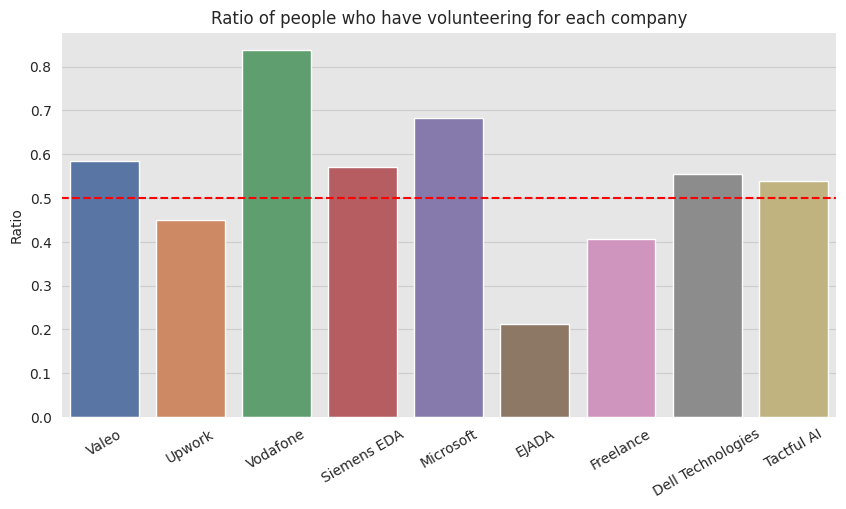

In [65]:
# for each company plot the ratio of people who have volunteering

# get the top 10 companies
companies = experience_df['Company'].value_counts().sort_values(ascending=False)[1:10].index

# get the ratio of people who have volunteering for each company
volunteer_ratio = []
for company in companies:
    volunteer_ratio.append(len(volunteer_df[volunteer_df['Company'] == company]) / len(experience_df[experience_df['Company'] == company]))

# plot the ratio of people who have volunteering for each company
plt.figure(figsize=(10, 5))
sns.barplot(x=companies, y=volunteer_ratio)
# plot threshold line
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xticks(rotation=30)
plt.ylabel('Ratio')
plt.title('Ratio of people who have volunteering for each company')
plt.show()